# Zacros kMC for O-Pt(111)

In [1]:
import numpy as np
from pathlib import Path
import subprocess, os
import scm.pyzacros as pz
import zacros_functions as zf
import matplotlib.pyplot as plt

In [2]:
# Path to Zacros executables
zacros_path = Path("/home/akandra/zacros/zacros_4.0/build_intel")
zacros3_path = Path("/home/akandra/zacros/zacros_3.03/build_std")

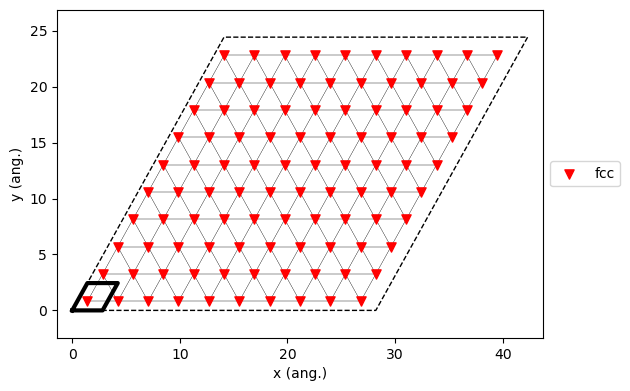

In [3]:
# Setting up a system and running Zacros simulations

# lattice setup
lattice_constant = 2.821135  # in Angstroms 
# lattice vectors for Pt(111)
unit_cell = lattice_constant*np.array([ 
                                [1.0,         0.0],
                                [0.5, np.sqrt(3)/2] ])
lat_size = "40x40"

# Zacros run directory
run_dir = "zacros_run"

# Adsorbates
ads_name = 'O*'

# Cluster definition
def clusters(n):

  # 2-body clusters up to 9nn for Pt(111) from Florian's DFT calculations
  cluster_list_all =  [0,     1,     2,      3,     4,     5,     6,     7,     8,    9]
  eng_list_all =    [0.0, 0.123, 0.029, -0.010, 0.023, 0.023, 0.015, 0.016, 0.030, 0.014]

  cluster_list = cluster_list_all[:n+1]
  eng_list = eng_list_all[:n+1]
  cl_dir = f'upto{n}nn'

  return cluster_list, eng_list, cl_dir

# Get lattice size from lat_size string
Nx_lat, Ny_lat = [int(y) for y in lat_size.split('x')]

# Visualize lattice using pyzacros
lattice = pz.Lattice(cell_vectors=unit_cell,
                        repeat_cell=[10,10],
                         site_types=["fcc"],
                   site_coordinates=[(0.333333333333333,0.333333333333333)],
                   neighboring_structure=[ [(0,0), pz.Lattice.NORTH],
                                           [(0,0), pz.Lattice.EAST],
                                           [(0,0), pz.Lattice.SOUTHEAST] ] )
lattice.plot()

In [26]:
# Loop over different coverages
temperature = 70  # in Kelvin
cluster_list, eng_list, cl_dir = clusters(2)

for coverage in [0.05]:

    wdir = Path(f"{run_dir}_{int(round(1000*coverage)):04d}_{cl_dir}_{temperature:04d}")
    try:
        wdir.mkdir(exist_ok=False)
    except FileExistsError:
        print(f"Directory {wdir} already exists. Skipping...")
        continue

    # Number of adsorbates
    N_ads = int(coverage * Nx_lat * Ny_lat)

    # Setup Zacros input 
    header = "Pt(111)"+lat_size
    zf.make_lattice_input(wdir, 1, 1, unit_cell, Nx_lat, Ny_lat, header=header)
    zf.make_mechanism_input(wdir, header=header)
    zf.make_energetics_input(wdir, cluster_list, eng_list)
    zf.make_state_input(wdir, [(ads_name,N_ads)], header=header)
    zf.make_simulation_input(wdir, temperature=temperature, max_steps=50000, snapshots='on event 500', wall_time=3600,   header=header)

    # Change to Zacros run directory
    original_dir = os.getcwd()
    os.chdir(wdir)

    try:
        # Run zacros.x
        result = subprocess.run([str(zacros_path / "zacros.x")], 
                            check=True,
                            capture_output=True,
                            text=True)
        print(result.stdout)
        
    except subprocess.CalledProcessError as e:
        print("Error running zacros.x:")
        print(e.stderr)
        
    finally:
        # Change back to original directory
        os.chdir(original_dir)
        


 Logger initialised at level INFO
 NO THREADS



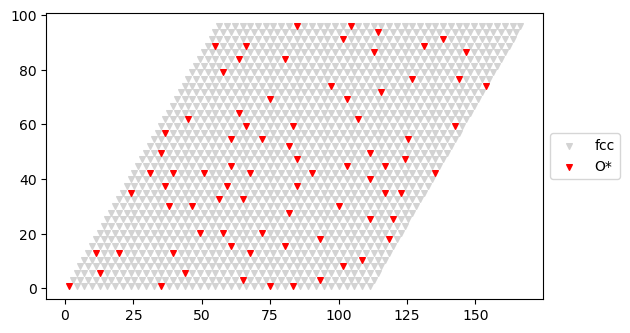

In [27]:
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto2nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

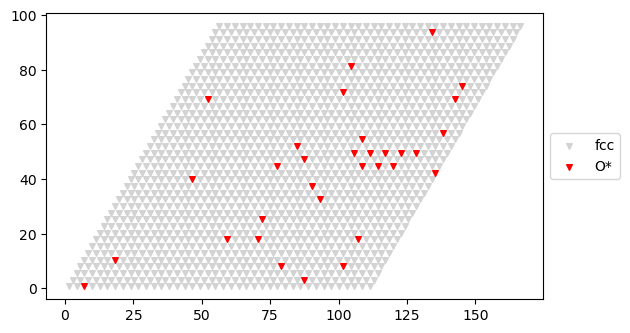

In [5]:
zf.lattice_plot(Path.cwd() /"zacros_run_0020_upto3nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

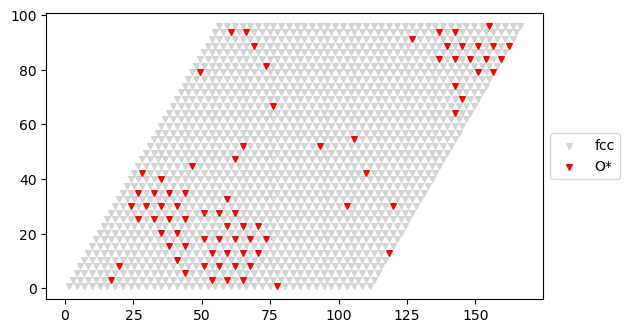

In [4]:

zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto3nn_0070/lattice_input.dat", show_axes=True, pause=0,close=False)

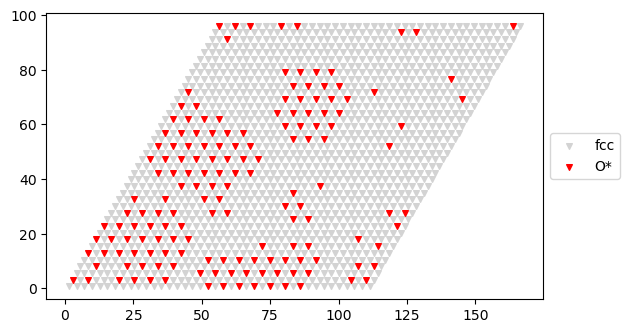

In [17]:
zf.lattice_plot(Path.cwd() /"zacros_run_0100_upto3nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

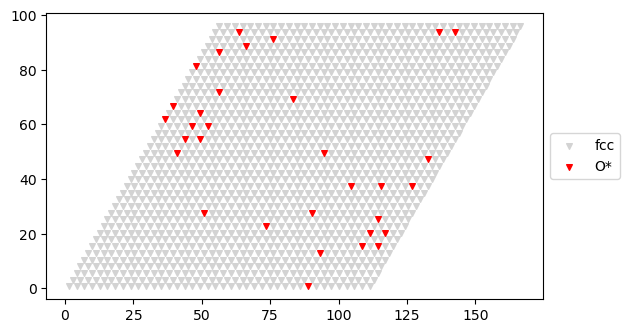

In [18]:
zf.lattice_plot(Path.cwd() /"zacros_run_0020_upto5nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

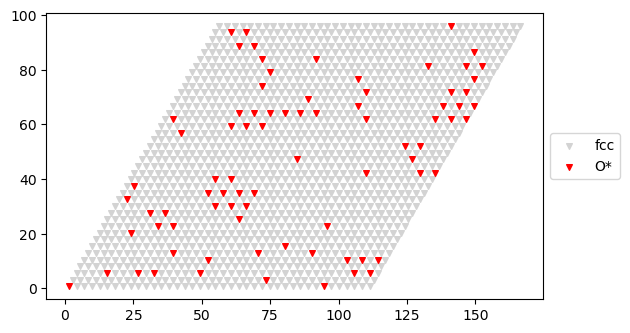

In [19]:
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto5nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

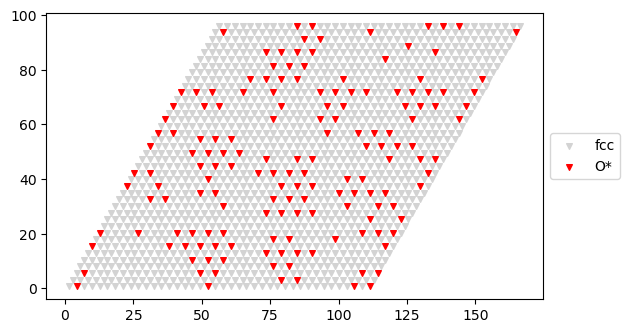

In [20]:
zf.lattice_plot(Path.cwd() /"zacros_run_0100_upto5nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

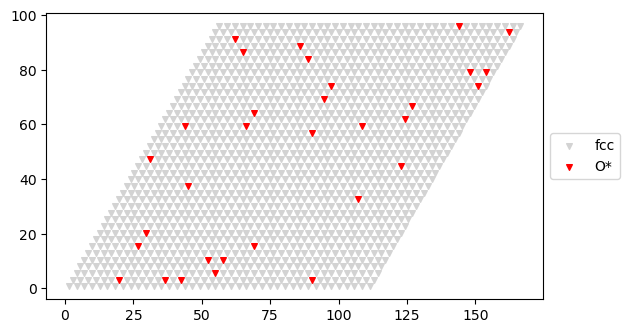

In [21]:
zf.lattice_plot(Path.cwd() /"zacros_run_0020_upto9nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

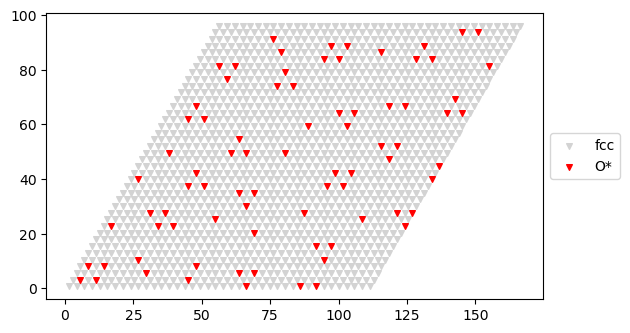

In [22]:
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto9nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

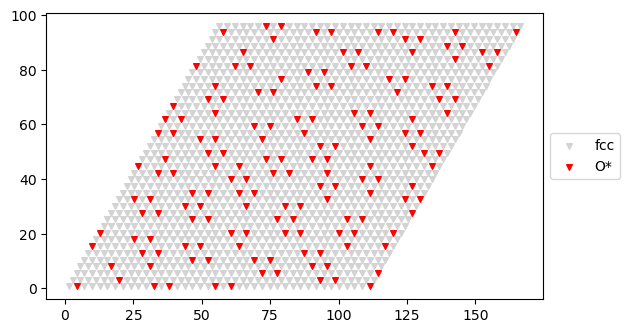

In [19]:
zf.lattice_plot(Path.cwd() /"zacros_run_0100_upto9nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

In [4]:
from scipy.spatial import cKDTree,ConvexHull

class UnionFind:
    def __init__(self, n):
        self.parent = np.arange(n)
        self.rank = np.zeros(n, dtype=int)

    def find(self, a):
        p = self.parent
        while p[a] != a:
            p[a] = p[p[a]]
            a = p[a]
        return a

    def union(self, a, b):
        ra = self.find(a); rb = self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        else:
            self.parent[rb] = ra
            if self.rank[ra] == self.rank[rb]:
                self.rank[ra] += 1

def cluster_points_periodic(points, v1, v2, cutoff):
    """
    Cluster 2D points with periodic boundary conditions.

    Parameters
    ----------
    points : (N,2) array_like
        Cartesian coordinates of points (float).
    v1, v2 : The box is spanned by v1 and v2.
    cutoff : float
        Distance cutoff for connectivity (e.g. 3rd NN distance).

    Returns
    -------
    labels : (N,) int
        Cluster label for each original point (0..nclusters-1).
    clusters : list of ndarray
        Indices of points in each cluster.
    sizes : list of int 
        Sizes of clusters (only if return_sizes True).
    """
    pts = np.asarray(points, dtype=float)
    if pts.size == 0:
      return np.array([], dtype=int), [], []

    N = len(pts)
    # Build augmented points = original points shifted by translations i*v1 + j*v2 with i,j in {-1,0,1}
    shifts = [(i, j) for i in (-1, 0, 1) for j in (-1, 0, 1)]
    aug_pts = np.zeros((N * len(shifts), 2), dtype=float)
    orig_idx = np.zeros(N * len(shifts), dtype=int)

    k = 0
    for si, (i, j) in enumerate(shifts):
        shift_vec = i * v1 + j * v2
        aug_pts[k:k+N] = pts + shift_vec
        orig_idx[k:k+N] = np.arange(N)
        k += N

    # KD-tree on augmented points
    tree = cKDTree(aug_pts)
    pairs = tree.query_pairs(cutoff, output_type='ndarray')  # array of shape (M,2)

    uf = UnionFind(N)
    for a, b in pairs:
        ia = orig_idx[a]
        ib = orig_idx[b]
        if ia != ib:
            uf.union(ia, ib)

    # Extract roots and relabel to contiguous labels
    roots = np.array([uf.find(i) for i in range(N)])
    unique_roots, inv = np.unique(roots, return_inverse=True)
    labels = inv
    clusters = [np.nonzero(labels == k)[0] for k in range(len(unique_roots))]
    sizes = [len(c) for c in clusters]

    return labels, clusters, sizes

def cluster_circularity_periodic(points, v1, v2, cutoff):
    """
    Cluster points with PBC and compute cluster area, perimeter and circularity.
    Returns a dict with:
      labels, clusters, sizes, areas, perimeters, circularities
    Notes:
      - Area/perimeter computed from convex hull of each cluster after unwrapping PBC.
      - Circularity = 4*pi*area / perimeter^2 (0 if area==0 or perimeter==0).
    """
    pts = np.asarray(points, dtype=float)
    labels, clusters, sizes = cluster_points_periodic(pts, v1, v2, cutoff)
    if len(clusters) == 0:
        return dict(labels=labels, clusters=clusters, sizes=sizes,
                    areas=[], perimeters=[], circularities=[])
    # Build matrix V so that p = V @ frac  (frac in R^2)
    V = np.vstack([np.asarray(v1), np.asarray(v2)]).T  # shape (2,2)
    invV = np.linalg.inv(V)
    frac = (invV @ pts.T).T   # fractional coordinates (may be outside [0,1))
    frac_mod = frac - np.floor(frac)  # map to [0,1)
    areas = []
    perimeters = []
    circularities = []
    for idxs in clusters:
        n = len(idxs)
        if n == 0:
            areas.append(0.0); perimeters.append(0.0); circularities.append(0.0); continue
        fi = frac_mod[idxs]  # shape (n,2)
        # compute cluster mean and unwrap each point by nearest integer shift towards mean
        mean_f = fi.mean(axis=0)
        # compute integer shifts that bring each point close to mean
        shifts = np.rint(mean_f - fi).astype(int)  # shape (n,2)
        fi_unwrapped = fi + shifts
        coords = (V @ fi_unwrapped.T).T  # unwrapped Cartesian coords
        if n == 1:
            areas.append(0.0); perimeters.append(0.0); circularities.append(0.0); continue
        if n == 2:
            d = np.linalg.norm(coords[0] - coords[1])
            area = 0.0
            perim = 2.0 * d
            circ = 0.0
            areas.append(area); perimeters.append(perim); circularities.append(circ); continue
        # n >= 3: convex hull
        try:
            hull = ConvexHull(coords)
            hull_pts = coords[hull.vertices]
            # perimeter
            diffs = np.diff(np.vstack([hull_pts, hull_pts[0]]), axis=0)
            perim = np.sqrt((diffs**2).sum(axis=1)).sum()
            area = hull.volume  # area for 2D
        except Exception:
            # fallback: compute convex hull by monotone chain if ConvexHull fails
            # simple fallback: approximate area/perimeter from bounding box
            xmin, ymin = coords.min(axis=0)
            xmax, ymax = coords.max(axis=0)
            area = (xmax - xmin) * (ymax - ymin)
            perim = 2.0 * ((xmax - xmin) + (ymax - ymin))
        circ = 4.0 * np.pi * area / (perim**2) if perim > 0 and area > 0 else 0.0
        areas.append(float(area)); perimeters.append(float(perim)); circularities.append(float(circ))
    return dict(labels=labels, clusters=clusters, sizes=sizes,
                areas=areas, perimeters=perimeters, circularities=circularities)

def plot_cluster_size_and_circularity(sizes, circularities, bins=None):
    """
    Quick plot helper: histogram of sizes and circularity distribution.
    """
    import matplotlib.pyplot as plt
    sizes = np.asarray(sizes)
    circularities = np.asarray(circularities)
    if bins is None:
        bins = np.arange(1, sizes.max()+2) if sizes.size>0 else 10
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    if sizes.size>0:
        ax[0].hist(sizes, bins=bins, color='C0', log=True)
        ax[0].set_xlabel('Cluster size (sites)'); ax[0].set_ylabel('Number of clusters (log)')
    else:
        ax[0].text(0.5,0.5,'no clusters',ha='center',va='center')
    if circularities.size>0:
        ax[1].hist(circularities[circularities>0], bins=30, color='C1')
        ax[1].set_xlabel('Circularity'); ax[1].set_ylabel('Counts')
    else:
        ax[1].text(0.5,0.5,'no circularities',ha='center',va='center')
    plt.tight_layout()
    plt.show()



n_clusters: 23, mean size: 3.48, median: 1.00


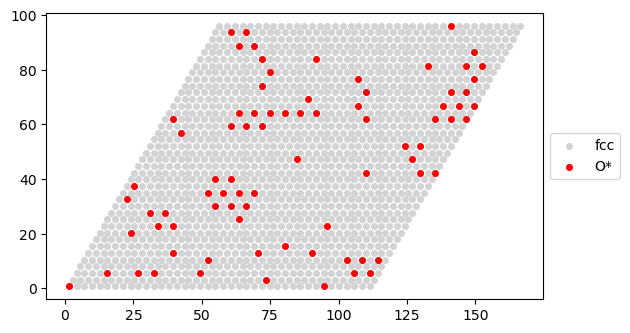

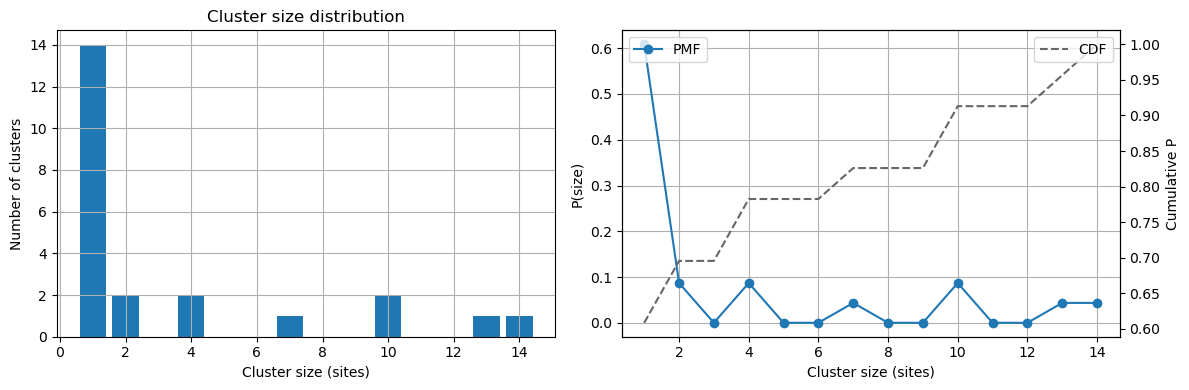

n clusters: 23


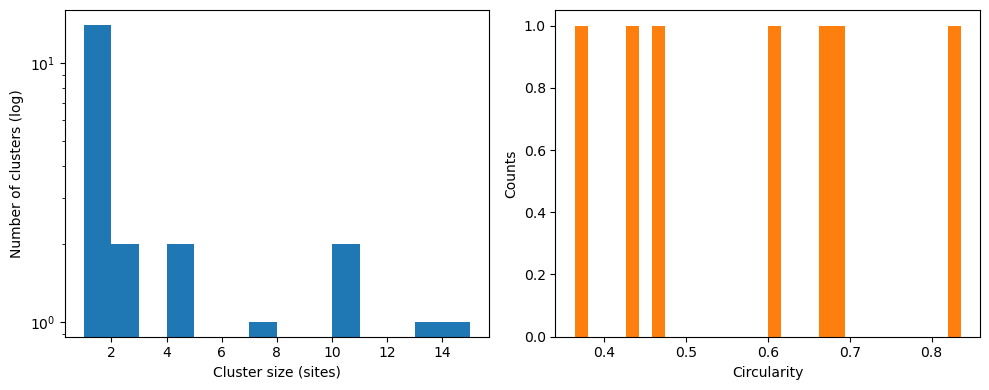

In [5]:
ads_coords,v1,v2 = zf.get_xy(Path.cwd() /"zacros_run_0050_upto5nn_0070/lattice_input.dat", idx=99)
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto5nn_0070/lattice_input.dat", idx=99)

labels, clusters, sizes = cluster_points_periodic(ads_coords, v1, v2, cutoff=2.001*lattice_constant)
zf.plot_cluster_size_distribution(sizes)

res = cluster_circularity_periodic(ads_coords, v1, v2, cutoff=2.001*lattice_constant)
print("n clusters:", len(res['clusters']))
plot_cluster_size_and_circularity(res['sizes'], res['circularities'])

In [ ]:
n_clusters = []
cluster_counts = []
lat_sizes = [f"{i}x{i}" for i in range(3, 15)]
for lat_size in lat_sizes:

    with open(run_dir / lat_size / 'energlist_output.txt', 'r') as file:
        lines = file.readlines()

    cl_names = lines[0].split()[1:]
    for i, line in enumerate(lines):
        if 'energetics_list_entry' in line: break
        
    n_clusters.append(int(lines[i+1].split()[0]))
    cluster_list = [int(line.split()[0]) for line in lines[i+2: i+2+n_clusters[-1]]]

    cluster_counts.append([cluster_list.count(i) for i in range(1, 11)])


# Extract lattice sizes as numbers (e.g., '3x3' -> 3)
x_vals = [int(size.split('x')[0]) for size in lat_sizes]

for i in range(10):

    plt.figure()
    plt.xlabel('Lattice Size (N)')
    plt.ylabel('# of Clusters / # of adsorbates')
    plt.title(f'# of {cl_names[i]} clusters')
    plt.grid(True)

    y_vals = [cluster_counts[l][i]/nsites**2 for l, nsites in enumerate(x_vals)]
    plt.plot(x_vals, y_vals,'o-')




TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
96/16

6.0